# Installation of Libraries
## Tidyverse

In [ ]:
install.packages("tidyverse")


The downloaded binary packages are in
	/var/folders/dk/fbw09gbs3_q7rcjts5635j5r0000gn/T//Rtmp4NXfwj/downloaded_packages

The downloaded binary packages are in
	/var/folders/dk/fbw09gbs3_q7rcjts5635j5r0000gn/T//Rtmp4NXfwj/downloaded_packages


## Helper/API libraries

In [7]:
install.packages(c(
    "ggridges",
    "knitr",
    "spotifyr",
    "tm",
    "wordcloud",
    "RColorBrewer"
))


The downloaded binary packages are in
	/var/folders/dk/fbw09gbs3_q7rcjts5635j5r0000gn/T//RtmpnPsDEm/downloaded_packages


# Importing Libraries

In [3]:
# core tidyverse
library(tidyverse)

# extended tidyverse
library(lubridate)
library(rvest)
library(tidyr)
library(forcats)

# external
library(spotifyr)
library(ggridges)
library(knitr)
library(tm)
library(wordcloud)
library(RColorBrewer)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.2
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘rvest’


The following object is masked from ‘package:readr’:

    guess_encoding




ERROR: Error in library(tm): there is no package called ‘tm’


# Function definitions
## Rate Your Music | https://rateyourmusic.com

Create some helpful functions for the data analysis part of the project

In [1]:
# Extract CSS Selectors
rym_get_album_ratings_highest_page <- function(page_number) {
  url <- paste0("https://rateyourmusic.com/charts/top/album/all-time/", page_number)
  webpage <- read_html(url)

  album_names <- webpage %>%
    html_nodes(".page_charts_section_charts_item_title") %>%
    html_text() %>%
    str_trim() # Remove any leading or trailing white spaces
  artists <- webpage %>%
    html_nodes(".page_charts_section_charts_item_credited_links_primary") %>%
    html_text() %>%
    str_trim() # Remove any leading or trailing white spaces
  ratings <- webpage %>%
    html_nodes(".page_charts_section_charts_item_details_average_num") %>%
    html_text(trim = TRUE) %>%
    as.numeric() # convert to numeric
  ratings <- ratings[seq(1, length(ratings), 2)]
  release_date <- webpage %>%
    html_nodes(".page_charts_section_charts_item_date span:first-child") %>%
    html_text() %>%
    str_trim() %>% # Remove any leading or trailing white spaces
    parse_date_time(orders = c("dmY", "my")) %>% # parse using multiple formats
    format("%d-%m-%Y") # format as dd-mm-yyyy
  genres <- webpage %>%
    html_nodes(".page_charts_section_charts_item_genres_primary") %>%
    map_chr(
      ~ .x %>% # This function from the purrr package is used to apply the nested function to each node, and ensures that the results are returned as character vectors.
        html_nodes("a") %>%
        html_text() %>%
        paste(collapse = ", ") # This results in a single string for each album that lists all associated genres in one go.
    )
  num_ratings <- webpage %>%
    html_nodes(".page_charts_section_charts_item_details_ratings .full") %>%
    html_text() %>%
    str_trim() %>% # Remove any leading or trailing white spaces
    str_remove_all(",") %>% # remove commas from numbers
    as.numeric() # convert to numeric
  num_views <- webpage %>%
    html_nodes(".page_charts_section_charts_item_details_reviews .full") %>%
    html_text() %>%
    str_trim() %>%
    str_replace_all(",", "") %>% # Removing commas
    as.numeric() # convert to numeric
  descriptors <- webpage %>%
    html_nodes(".page_charts_section_charts_item_genre_descriptors") %>%
    html_text(trim = TRUE) %>%
    str_replace_all("\n", ", ") %>%
    str_squish()
    # Check and fix length issues
  if(length(genres) != length(album_names)) {
    # Find positions where values may be missing
    missing_indices <- setdiff(1:length(album_names), 1:length(genres))
    # Insert NA for missing values
    genres <- map2_chr(1:length(album_names), missing_indices, 
                       ~ if (.x %in% .y) NA_character_ else genres[.x])
  }
  
  if(length(descriptors) != length(album_names)) {
    missing_indices <- setdiff(1:length(album_names), 1:length(descriptors))
    descriptors <- map2_chr(1:length(album_names), missing_indices, 
                            ~ if (.x %in% .y) NA_character_ else descriptors[.x])
  }
  df <- data.frame(
    Album = album_names,
    Artist = artists,
    Rating = ratings,
    ReleaseDate = release_date,
    Genres = genres,
    Descriptors = descriptors,
    NumberOfRatings = num_ratings,
    NumberOfViews = num_views
  )
  # Adding a ranking column
  df <- df %>% mutate(Ranking = row_number())
  # To ensure the Ranking column is first
  df <- df %>% select(Ranking, everything())

  df
}

In [45]:
rym_get_album_rating <- function(album_name) {
    album_name %>%
        gsub(" ", "%20", .) %>%
        paste0("https://rateyourmusic.com/search?searchterm=", .) %>%
        read_html() %>%
        html_element("td") %>%
        html_elements("a") %>%
        .[[2]] %>%
        html_attr("href") %>%
        paste0("https://rateyourmusic.com", .) %>%
        read_html() %>%
        html_element("span .avg_rating") %>%
        html_text2() %>%
        as.numeric()
}

### Helper function examples

In [4]:
rym_get_album_ratings_highest_page(1) %>% head()

,Ranking,Album,Artist,Rating,ReleaseDate,Genres,Descriptors,NumberOfRatings,NumberOfViews
,<int>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>
1,1,To Pimp a Butterfly,Kendrick Lamar,4.36,15-03-2015,"Conscious Hip Hop, West Coast Hip Hop, Jazz Rap","political, conscious, concept album, poetic, introspective, urban, protest, eclectic",70131,599
2,2,OK Computer,Radiohead,4.27,16-06-1997,"Alternative Rock, Art Rock","melancholic, anxious, alienation, futuristic, existential, lonely, atmospheric, cold",95227,1718
3,3,Wish You Were Here,Pink Floyd,4.32,12-09-1975,"Progressive Rock, Art Rock","melancholic, atmospheric, progressive, concept album, serious, longing, introspective, alienation",65613,996
4,4,Madvillainy,Madvillain,4.33,23-03-2004,Abstract Hip Hop,"sampling, playful, humorous, abstract, cryptic, mysterious, eclectic, surreal",54649,472
5,5,In Rainbows,Radiohead,4.29,10-10-2007,"Art Rock, Alternative Rock","lush, melancholic, introspective, bittersweet, atmospheric, mellow, warm, ethereal",69050,875
6,6,In the Court of the Crimson King,King Crimson,4.31,10-10-1969,"Progressive Rock, Art Rock","fantasy, epic, progressive, complex, poetic, surreal, philosophical, technical",60330,947


In [4]:
rym_get_album_rating("MM FOOD")

[1] 4.14

## Spotify API | https://developer.spotify.com/documentation/web-api

Firstly, set client ID and secret (previous secrets in repo have been burned)



In [7]:
Sys.setenv(SPOTIFY_CLIENT_ID = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
Sys.setenv(SPOTIFY_CLIENT_SECRET = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

Use the IDs to get the Spotify application access token

In [8]:
access_token <- get_spotify_access_token()

Create some helpful functions for the data analysis part of the project

In [3]:
spotify_get_album <- function(album_name) {
    album <- album_name %>% 
        search_spotify(type=c("album")) %>%
        .[1, ] %>% # get first search result for album name
        .$id %>% # retrieve ID
        get_album() # get album from ID

    album$tracks <- album$tracks$items %>%
        # convert duration from ms to s
        mutate(duration_s = round(duration_ms / 1000)) %>%
        # select only required columns
        select(name, track_number, disc_number, duration_s, explicit, id)

    album$artists <- album$artists %>% # select only required columns
        select(name, id)

    # select only required columns
    album[c("artists", "id", "label", "name", "popularity", "release_date", "tracks")]

}

In [4]:

spotify_get_song <- function(song_name) {
    song <- song_name %>%
        search_spotify(type = c("track")) %>%
        .[1, ] %>% # get first search result for album name
        .$id %>% # retreive ID
        get_track() # get album from ID

    song$artists <- song$artists %>%
        select(name, id)

    # convert duration from ms to s
    song$duration_s <- round(song$duration_ms / 1000)

    # select only required columns
    song$features <- get_track_audio_features(song$id) %>%
        select(-id, -uri, -track_href, -analysis_url, -duration_ms, -type)

    # select only required columns
    song[c("artists", "id", "name",  "duration_e", "explicit", "popularity", "track_number", "features")]
}

In [9]:
spotify_get_artist <- function(artist_name) {
    artist <- artist_name %>%
        search_spotify(type = c("artist")) %>%
        .[1, ] %>% # get first search result for artist name
        .$id %>% # retreive ID
        get_artist() # get artist from ID


    # select only required columns
    artist$followers <- artist$followers$total

    # select only required columns
    artist[c("followers", "genres", "id", "name", "popularity")]
}

### Helper function examples

In [10]:
spotify_get_album("DAMN.")

$artists
            name                     id
1 Kendrick Lamar 2YZyLoL8N0Wb9xBt1NhZWg

$id
[1] "4eLPsYPBmXABThSJ821sqY"

$label
[1] "Aftermath"

$name
[1] "DAMN."

$popularity
[1] 85

$release_date
[1] "2017-04-14"

$tracks
                      name track_number disc_number duration_s explicit
1                   BLOOD.            1           1        118     TRUE
2                     DNA.            2           1        186     TRUE
3                     YAH.            3           1        160     TRUE
4                 ELEMENT.            4           1        209     TRUE
5                    FEEL.            5           1        215     TRUE
6  LOYALTY. FEAT. RIHANNA.            6           1        227     TRUE
7                   PRIDE.            7           1        275     TRUE
8                  HUMBLE.            8           1        177     TRUE
9                    LUST.            9           1        308     TRUE
10     LOVE. FEAT. ZACARI.           10           1        213     TRUE
11          XXX. FEAT. U2.           11           1        254     TRUE
12                   FEAR.           12           1        461     TRUE
13                    GOD.           13           1        249     TRUE
14              DUCKWORTH.           14           1        249     TRUE
                       id
1  1n4jwRVXdkK2U34nBDUKKT
2  6HZILIRieu8S0iqY8kIKhj
3  4BHSjbYylfOH5WAGusDyni
4  1EaKU4dMbesXXd3BrLCtYG
5  2LTlO3NuNVN70lp2ZbVswF
6  6SwRhMLwNqEi6alNPVG00n
7  6IZvVAP7VPPnsGX6bvgkqg
8  7KXjTSCq5nL1LoYtL7XAwS
9  06FCvd7rrRcF3DdvWH5Isp
10 6PGoSes0D9eUDeeAafB2As
11 4iYRa2btalAzPZoSYfROqF
12 23luOrEVHMfoX0AhfbQuS6
13 5p3NP9mQblDsVJLdfNZJ3I
14 0y9uTzK9cNKSAEHnpeRG8C

In [26]:
spotify_get_song("Pacific State")

$artists
       name                     id
1 808 State 7hFdUW64G4iU1tz46ITRfN

$id
[1] "2h7w0KHwHbx4WbG6WxjO7U"

$name
[1] "Pacific State"

$duration_s
[1] 351

$explicit
[1] FALSE

$popularity
[1] 53

$track_number
[1] 1

$features
# A tibble: 1 × 12
  danceability energy   key loudness  mode speechiness acousticness
         <dbl>  <dbl> <int>    <dbl> <int>       <dbl>        <dbl>
1        0.682  0.979    10    -6.50     0      0.0733       0.0649
# ℹ 5 more variables: instrumentalness <dbl>, liveness <dbl>, valence <dbl>,
#   tempo <dbl>, time_signature <int>

In [27]:
spotify_get_artist("St Germain")

$followers
[1] 291346

$genres
[1] "downtempo"   "electronica" "jazztronica" "nu jazz"    

$id
[1] "484sZUYmnRXN84zmk3GY1n"

$name
[1] "St Germain"

$popularity
[1] 50

## Best Selling Albums | https://bestsellingalbums.org

Create some helpful functions for the data analysis part of the project

In [34]:
album_charts_get_all_time <- function() {
    albums <- "https://bestsellingalbums.org/overall/" %>%
        read_html() %>%
        # get card elements
        html_elements(".album_card")

    tibble(
        Name = albums %>%
        html_element(".album") %>%
        html_text2(), # convert to text
        Artist = albums %>%
        html_element(".artist") %>%
        html_text2(), # convert to text
        Sales = albums %>%
        html_nodes(".sales") %>%
        html_text2() %>% # convert to text
        gsub("\\D", "", .) %>%
        as.numeric(), # remove non digits and convert to numeric
        Rank = albums %>%
        html_element(".rank") %>%
        html_text() %>% # convert to numeric
        as.numeric(),
        `Rank (All time)` = albums %>%
        html_nodes(".ranks_row") %>%
        html_element(":nth-child(3)") %>%
        html_text() %>%
        gsub("\\D", "", .) %>%
        as.numeric() # remove non digits and convert to numeric
    )
}

In [35]:
album_charts_get_artist <- function(artist) {
  albums <- "https://bestsellingalbums.org/artist/" %>%
    paste0(artist) %>%
    read_html() %>%
    html_elements(".album_card")
  
  tibble(
    Name = albums %>%
      html_element(".album") %>%
      html_text2(), # convert to text
    Artist = albums %>%
      html_element(".artist") %>%
      html_text2(), # convert to text
    Sales = albums %>%
      html_nodes(".sales") %>%
      html_text2() %>%
      gsub("\\D", "", .) %>%
      as.numeric(), # remove non digits and convert to numeric
    Rank = albums %>%
      html_element(".rank") %>%
      html_text() %>%
      as.numeric(), # convert to numeric
    `Rank (All time)` = albums %>%
      html_nodes(".ranks_row") %>%
      html_element(":nth-child(3)") %>%
      html_text() %>%
      gsub("\\D", "", .) %>%
      as.numeric() # remove non digits and convert to numeric
  )
}

### Helper function examples

In [36]:
album_charts_get_all_time() %>% head()

Name,Artist,Sales,Rank,Rank (All time)
<chr>,<chr>,<dbl>,<dbl>,<dbl>
THRILLER,MICHAEL JACKSON,6.6e+07,1,1
BACK IN BLACK,AC/DC,5.0e+07,2,2
DARK SIDE OF THE MOON,PINK FLOYD,5.0e+07,3,3
THE BODYGUARD (SOUNDTRACK),WHITNEY HOUSTON,4.5e+07,4,4
BAD,MICHAEL JACKSON,4.5e+07,5,5
BAT OUT OF HELL,MEAT LOAF,4.3e+07,6,6


In [37]:
mac_miller_id <- 8159
album_charts_get_artist(mac_miller_id)

Name,Artist,Sales,Rank,Rank (All time)
<chr>,<chr>,<dbl>,<dbl>,<dbl>
SWIMMING (2018),MAC MILLER,2125863,1,2246
CIRCLES (2020),MAC MILLER,570000,2,8768
BLUE SLIDE PARK (2011),MAC MILLER,540000,3,9362
GO:OD AM (2015),MAC MILLER,500000,4,9926
WATCHING MOVIES WITH THE SOUND OFF (2013),MAC MILLER,500000,5,9989
THE DIVINE FEMININE (2016),MAC MILLER,10000,6,55544


# Analysis and Results

In [19]:
access_token <- get_spotify_access_token()

Average energy - top 20 albums

In [ ]:
top_20_albums <- album_charts_get_all_time() %>% head(20)

top_20_albums %>% head(5)

Name,Artist,Sales,Rank,Rank (All time)
<chr>,<chr>,<dbl>,<dbl>,<dbl>
THRILLER,MICHAEL JACKSON,6.6e+07,1,1
BACK IN BLACK,AC/DC,5.0e+07,2,2
DARK SIDE OF THE MOON,PINK FLOYD,5.0e+07,3,3
THE BODYGUARD (SOUNDTRACK),WHITNEY HOUSTON,4.5e+07,4,4
BAD,MICHAEL JACKSON,4.5e+07,5,5


In [ ]:
(energy <- paste(top_20_albums$Name, top_20_albums$Artist) %>% lapply(function(album) {
    spotify_get_album(album)$tracks %>%
        .$id %>%
        lapply(spotifyr::get_track_audio_features) %>%
        lapply(function(track) track$energy) %>%
        as.numeric() %>%
        mean()
}))

[[1]]
[1] 0.5853333

[[2]]
[1] 0.8469

[[3]]
[1] 0.40045

[[4]]
[1] 0.5518917

[[5]]
[1] 0.7464583

[[6]]
[1] 0.635

[[7]]
[1] 0.4342222

[[8]]
[1] 0.54

[[9]]
[1] 0.6184167

[[10]]
[1] 0.6365625

[[11]]
[1] 0.7636667

[[12]]
[1] 0.503832

[[13]]
[1] 0.6696875

[[14]]
[1] 0.6802308

[[15]]
[1] 0.8105833

[[16]]
[1] 0.2532923

[[17]]
[1] 0.6762222

[[18]]
[1] 0.6623333

[[19]]
[1] 0.514375

[[20]]
[1] 0.7267368

In [ ]:
top_20_albums$energy <- unlist(energy)

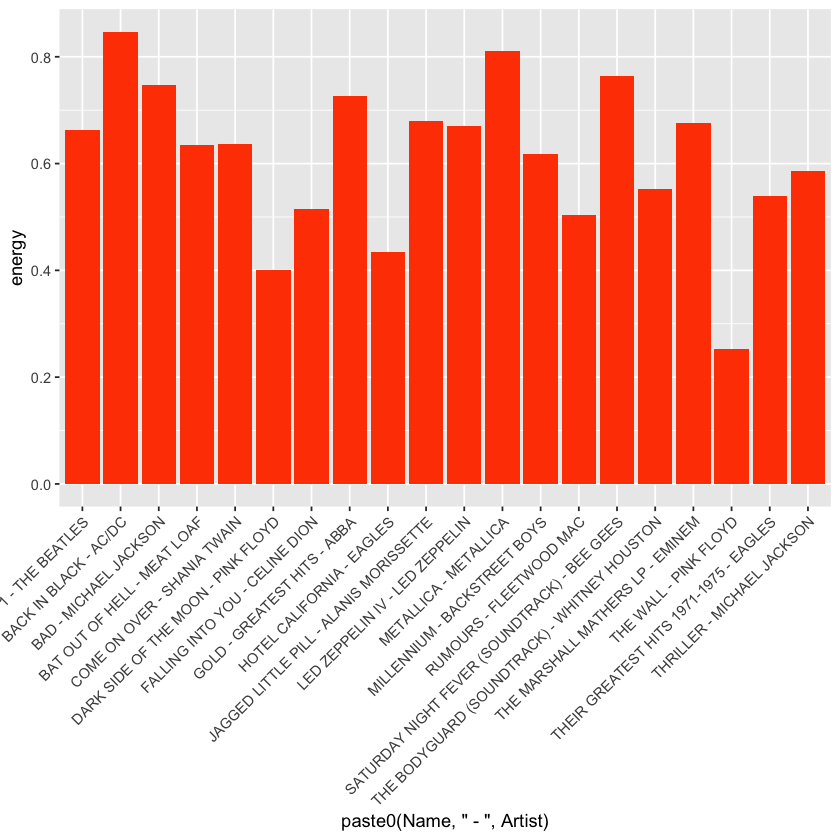

In [ ]:
ggplot(top_20_albums, aes(x = paste0(Name, " - ", Artist), y = energy)) +
    geom_bar(stat = "identity", fill = "orangered") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

Red hot chili peppers deep dive

In [20]:
## Get audio features for all tracks
rhcp <- get_artist_audio_features('red hot chili peppers')

head(rhcp)

,artist_name,artist_id,album_id,album_type,album_images,album_release_date,album_release_year,album_release_date_precision,danceability,energy,⋯,track_name,track_preview_url,track_number,type,track_uri,external_urls.spotify,album_name,key_name,mode_name,key_mode
,<chr>,<chr>,<chr>,<chr>,<list>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Red Hot Chili Peppers,0L8ExT028jH3ddEcZwqJJ5,0KJc9ksnoJJsdpQxV3z5i1,album,"640 , 300 , 64 , https://i.scdn.co/image/ab67616d0000b273aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00001e02aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00004851aa50644f05f26e73ba950b8c, 640 , 300 , 64",2022-10-14,2022,day,0.573,0.913,⋯,Tippa My Tongue,https://p.scdn.co/mp3-preview/b8201773e1af3c5fdaa321fb34cf9e75756d82ba?cid=4897f93fed274f22ae0ab93206c86b68,1,track,spotify:track:7BCxIjRsqbc9Yiy2haBCIK,https://open.spotify.com/track/7BCxIjRsqbc9Yiy2haBCIK,Return of the Dream Canteen,F,minor,F minor
2,Red Hot Chili Peppers,0L8ExT028jH3ddEcZwqJJ5,0KJc9ksnoJJsdpQxV3z5i1,album,"640 , 300 , 64 , https://i.scdn.co/image/ab67616d0000b273aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00001e02aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00004851aa50644f05f26e73ba950b8c, 640 , 300 , 64",2022-10-14,2022,day,0.680,0.679,⋯,Peace and Love,https://p.scdn.co/mp3-preview/a93ec9ed459cf4c2fe6c80b5c1141d0ed10da67a?cid=4897f93fed274f22ae0ab93206c86b68,2,track,spotify:track:3W2reBya7FkjHCP1B2nmQr,https://open.spotify.com/track/3W2reBya7FkjHCP1B2nmQr,Return of the Dream Canteen,A#,major,A# major
3,Red Hot Chili Peppers,0L8ExT028jH3ddEcZwqJJ5,0KJc9ksnoJJsdpQxV3z5i1,album,"640 , 300 , 64 , https://i.scdn.co/image/ab67616d0000b273aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00001e02aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00004851aa50644f05f26e73ba950b8c, 640 , 300 , 64",2022-10-14,2022,day,0.663,0.710,⋯,Reach Out,https://p.scdn.co/mp3-preview/eccd28cee4146ab727693a9bd3119b056c897407?cid=4897f93fed274f22ae0ab93206c86b68,3,track,spotify:track:00B7SBwrjbycLMOgAmeIU8,https://open.spotify.com/track/00B7SBwrjbycLMOgAmeIU8,Return of the Dream Canteen,B,minor,B minor
4,Red Hot Chili Peppers,0L8ExT028jH3ddEcZwqJJ5,0KJc9ksnoJJsdpQxV3z5i1,album,"640 , 300 , 64 , https://i.scdn.co/image/ab67616d0000b273aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00001e02aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00004851aa50644f05f26e73ba950b8c, 640 , 300 , 64",2022-10-14,2022,day,0.515,0.809,⋯,Eddie,https://p.scdn.co/mp3-preview/2146a69931d60eb834c8a41315ee7d962567325b?cid=4897f93fed274f22ae0ab93206c86b68,4,track,spotify:track:0G1BEi8ByngMCJqcPnDACw,https://open.spotify.com/track/0G1BEi8ByngMCJqcPnDACw,Return of the Dream Canteen,A,minor,A minor
5,Red Hot Chili Peppers,0L8ExT028jH3ddEcZwqJJ5,0KJc9ksnoJJsdpQxV3z5i1,album,"640 , 300 , 64 , https://i.scdn.co/image/ab67616d0000b273aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00001e02aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00004851aa50644f05f26e73ba950b8c, 640 , 300 , 64",2022-10-14,2022,day,0.599,0.777,⋯,Fake as Fu@k,https://p.scdn.co/mp3-preview/0c6b456dfc40827ab2da4dab414dd029fae2e034?cid=4897f93fed274f22ae0ab93206c86b68,5,track,spotify:track:7cpC2EuFMexgy392K13RZb,https://open.spotify.com/track/7cpC2EuFMexgy392K13RZb,Return of the Dream Canteen,G#,minor,G# minor
6,Red Hot Chili Peppers,0L8ExT028jH3ddEcZwqJJ5,0KJc9ksnoJJsdpQxV3z5i1,album,"640 , 300 , 64 , https://i.scdn.co/image/ab67616d0000b273aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00001e02aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00004851aa50644f05f26e73ba950b8c, 640 , 300 , 64",2022-10-14,2022,day,0.492,0.815,⋯,Bella,https://p.scdn.co/mp3-preview/10379f8e3e11558025d68f9ef26be4033493cca6?cid=4897f93fed274f22ae0ab93206c86b68,6,track,spotify:track:2dbA4sPwu3iK72c0mA6907,https://open.spotify.com/track/2dbA4sPwu3iK72c0mA6907,Return of the Dream Canteen,G

In [21]:
## Average energy by album
album.energy <- rhcp %>% 
  group_by(album_name) %>% 
  summarise(energy = mean(energy), release = mean(album_release_year)) 

In [22]:
## Remove non-deluxe versions of repeated albums
album.energy2 <- subset(album.energy,
                          !album_name %in% c("One Hot Minute", 
                                             "Californication",
                                             "By the Way"))
album.energy2

album_name,energy,release
<chr>,<dbl>,<dbl>
Blood Sugar Sex Magik (Deluxe Edition),0.7528421,1991
By the Way (Deluxe Edition),0.8266667,2002
Californication (Deluxe Edition),0.8450000,1999
Freaky Styley,0.8505556,1985
I'm with You,0.8624286,2011
Mother's Milk,0.9309474,1989
One Hot Minute (Deluxe Edition),0.7637500,1995
Red Hot Chili Peppers,0.8293125,1984
Return of the Dream Canteen,0.7112353,2022


In [23]:
## Ordered from earliest to latest
energy.ordered <- 
  album.energy2[order(album.energy2$release, decreasing = F),]
energy.ordered

album_name,energy,release
<chr>,<dbl>,<dbl>
Red Hot Chili Peppers,0.8293125,1984
Freaky Styley,0.8505556,1985
The Uplift Mofo Party Plan,0.9155833,1987
Mother's Milk,0.9309474,1989
Blood Sugar Sex Magik (Deluxe Edition),0.7528421,1991
One Hot Minute (Deluxe Edition),0.7637500,1995
Californication (Deluxe Edition),0.8450000,1999
By the Way (Deluxe Edition),0.8266667,2002
Stadium Arcadium,0.7801034,2006


In [24]:
## Ordered from most energy to least
album.energy2[order(album.energy2$energy, decreasing = T),]
## 3 of the 4 most energetic albums were released in the 80s, before they were 
## mainstream.


album_name,energy,release
<chr>,<dbl>,<dbl>
Mother's Milk,0.9309474,1989
The Uplift Mofo Party Plan,0.9155833,1987
I'm with You,0.8624286,2011
Freaky Styley,0.8505556,1985
Californication (Deluxe Edition),0.8450000,1999
Red Hot Chili Peppers,0.8293125,1984
By the Way (Deluxe Edition),0.8266667,2002
Stadium Arcadium,0.7801034,2006
One Hot Minute (Deluxe Edition),0.7637500,1995


In [25]:
## Top 5 energy tracks
top5.en <- rhcp %>% 
  arrange(-energy) %>% 
  select(track_name, energy, album_release_year) %>% 
  head(5)
top5.en
## All of the 5 most energetic tracks released by the RHCP
## were released in the 80s.

,track_name,energy,album_release_year
,<chr>,<dbl>,<dbl>
1,Catholic School Girls Rule - Remastered,0.998,1985
2,Subway To Venus - Remastered,0.997,1989
3,"Johnny, Kick A Hole In The Sky - Remastered",0.997,1989
4,Me And My Friends,0.996,1987
5,Freaky Styley - Remastered,0.996,1985


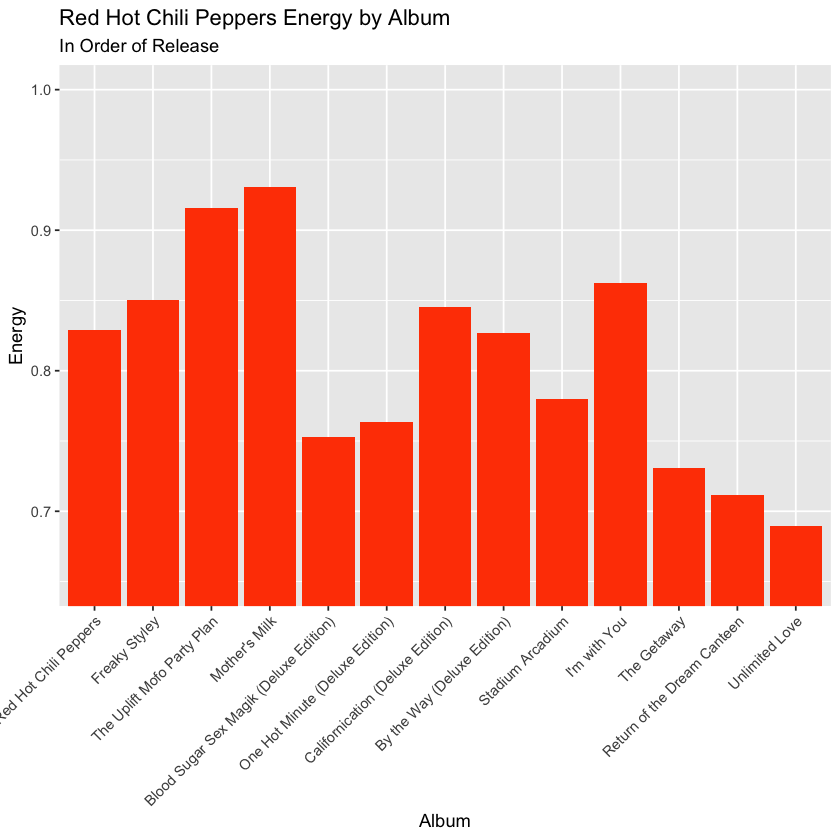

In [26]:
## Plot release vs energy
ggplot(energy.ordered, aes(x = reorder(album_name, release), y = energy)) +
  geom_bar(stat = "identity", fill = "orangered") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  xlab("Album") +
  ylab("Energy") +
  coord_cartesian(ylim = c(0.65,1)) +
  ggtitle("Red Hot Chili Peppers Energy by Album",
          subtitle = "In Order of Release")

In [27]:
## Change order of album
rhcp2 <- rhcp
rhcp2$album_name <- as.factor(rhcp2$album_name)
rhcp2 <- rhcp %>%
  mutate(album_name = fct_reorder(album_name, desc(album_release_date)))

Picking joint bandwidth of 0.0645



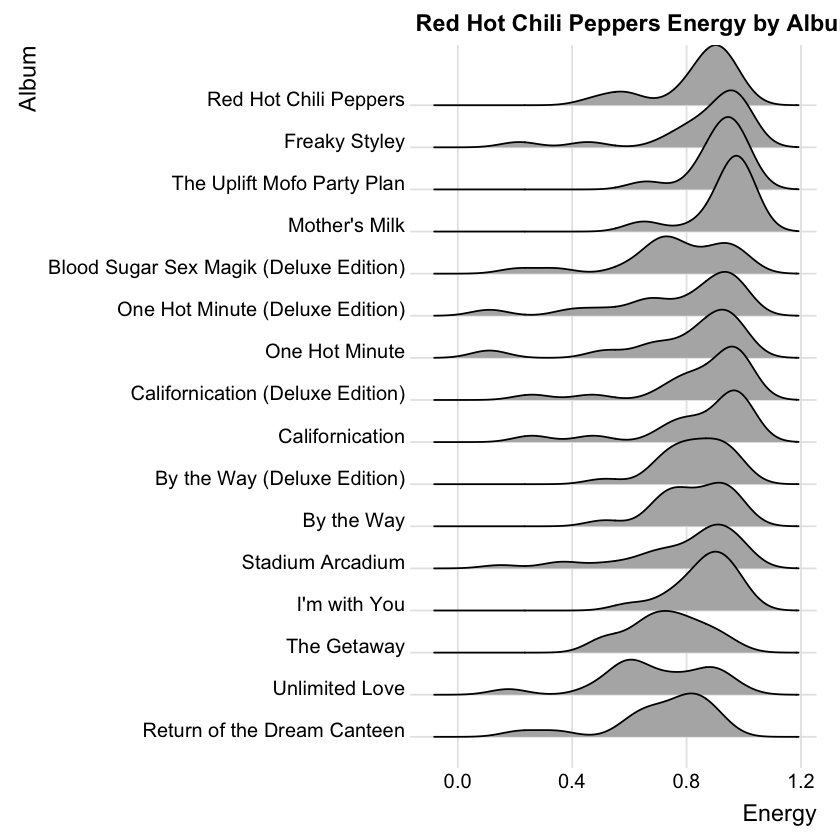

In [28]:
## Density plot of album energy
ggplot(rhcp2, aes(x = energy, y = album_name)) + 
  geom_density_ridges() + 
  theme_ridges() +
  xlab("Energy") +
  ylab("Album") +
  ggtitle("Red Hot Chili Peppers Energy by Album")

In [29]:
## Album dataframe
rhcp.albums <- subset(get_artist_albums('0L8ExT028jH3ddEcZwqJJ5'), 
                      album_type == 'album')
head(rhcp.albums)

,album_group,album_type,artists,available_markets,href,id,images,name,release_date,release_date_precision,total_tracks,type,uri,external_urls.spotify
,<chr>,<chr>,<list>,<list>,<chr>,<chr>,<list>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
1,album,album,"https://api.spotify.com/v1/artists/0L8ExT028jH3ddEcZwqJJ5, 0L8ExT028jH3ddEcZwqJJ5 , Red Hot Chili Peppers , artist , spotify:artist:0L8ExT028jH3ddEcZwqJJ5 , https://open.spotify.com/artist/0L8ExT028jH3ddEcZwqJJ5","AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY, CZ, DK, DO, DE, EC, EE, SV, FI, FR, GR, GT, HN, HK, HU, IS, IE, IT, LV, LT, LU, MY, MT, MX, NL, NZ, NI, NO, PA, PY, PE, PH, PL, PT, SG, SK, ES, SE, CH, TW, TR, UY, US, GB, AD, LI, MC, ID, JP, TH, VN, RO, IL, ZA, SA, AE, BH, QA, OM, KW, EG, MA, DZ, TN, LB, JO, PS, IN, KZ, MD, UA, AL, BA, HR, ME, MK, RS, SI, KR, BD, PK, LK, GH, KE, NG, TZ, UG, AG, AM, BS, BB, BZ, BT, BW, BF, CV, CW, DM, FJ, GM, GE, GD, GW, GY, HT, JM, KI, LS, LR, MW, MV, ML, MH, FM, NA, NR, NE, PW, PG, WS, SM, ST, SN, SC, SL, SB, KN, LC, VC, SR, TL, TO, TT, TV, VU, AZ, BN, BI, KH, CM, TD, KM, GQ, SZ, GA, GN, KG, LA, MO, MR, MN, NP, RW, TG, UZ, ZW, BJ, MG, MU, MZ, AO, CI, DJ, ZM, CD, CG, IQ, LY, TJ, VE, ET, XK",https://api.spotify.com/v1/albums/0KJc9ksnoJJsdpQxV3z5i1,0KJc9ksnoJJsdpQxV3z5i1,"640 , 300 , 64 , https://i.scdn.co/image/ab67616d0000b273aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00001e02aa50644f05f26e73ba950b8c, https://i.scdn.co/image/ab67616d00004851aa50644f05f26e73ba950b8c, 640 , 300 , 64",Return of the Dream Canteen,2022-10-14,day,17,album,spotify:album:0KJc9ksnoJJsdpQxV3z5i1,https://open.spotify.com/album/0KJc9ksnoJJsdpQxV3z5i1
2,album,album,"https://api.spotify.com/v1/artists/0L8ExT028jH3ddEcZwqJJ5, 0L8ExT028jH3ddEcZwqJJ5 , Red Hot Chili Peppers , artist , spotify:artist:0L8ExT028jH3ddEcZwqJJ5 , https://open.spotify.com/artist/0L8ExT028jH3ddEcZwqJJ5","AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY, CZ, DK, DO, DE, EC, EE, SV, FI, FR, GR, GT, HN, HK, HU, IS, IE, IT, LV, LT, LU, MY, MT, MX, NL, NZ, NI, NO, PA, PY, PE, PH, PL, PT, SG, SK, ES, SE, CH, TW, TR, UY, US, GB, AD, LI, MC, ID, JP, TH, VN, RO, IL, ZA, SA, AE, BH, QA, OM, KW, EG, MA, DZ, TN, LB, JO, PS, IN, KZ, MD, UA, AL, BA, HR, ME, MK, RS, SI, KR, BD, PK, LK, GH, KE, NG, TZ, UG, AG, AM, BS, BB, BZ, BT, BW, BF, CV, CW, DM, FJ, GM, GE, GD, GW, GY, HT, JM, KI, LS, LR, MW, MV, ML, MH, FM, NA, NR, NE, PW, PG, WS, SM, ST, SN, SC, SL, SB, KN, LC, VC, SR, TL, TO, TT, TV, VU, AZ, BN, BI, KH, CM, TD, KM, GQ, SZ, GA, GN, KG, LA, MO, MR, MN, NP, RW, TG, UZ, ZW, BJ, MG, MU, MZ, AO, CI, DJ, ZM, CD, CG, IQ, LY, TJ, VE, ET, XK",https://api.spotify.com/v1/albums/2ITVvrNiINKRiW7wA3w6w6,2ITVvrNiINKRiW7wA3w6w6,"640 , 300 , 64 , https://i.scdn.co/image/ab67616d0000b27397a52e0aeda9d95fb881c56d, https://i.scdn.co/image/ab67616d00001e0297a52e0aeda9d95fb881c56d, https://i.scdn.co/image/ab67616d0000485197a52e0aeda9d95fb881c56d, 640 , 300 , 64",Unlimited Love,2022-04-01,day,17,album,spotify:album:2ITVvrNiINKRiW7wA3w6w6,https://open.spotify.com/album/2ITVvrNiINKRiW7wA3w6w6
3,album,album,"https://api.spotify.com/v1/artists/0L8ExT028jH3ddEcZwqJJ5, 0L8ExT028jH3ddEcZwqJJ5 , Red Hot Chili Peppers , artist , spotify:artist:0L8ExT028jH3ddEcZwqJJ5 , https://open.spotify.com/artist/0L8ExT028jH3ddEcZwqJJ5","AR, AU, AT, BE, BO, BR, BG, CA, CL, CO, CR, CY, CZ, DK, DO, DE, EC, EE, SV, FI, FR, GR, GT, HN, HK, HU, IS, IE, IT, LV, LT, LU, MY, MT, MX, NL, NZ, NI, NO, PA, PY, PE, PH, PL, PT, SG, SK, ES, SE, CH, TW, TR, UY, US, GB, AD, LI, MC, ID, JP, TH, VN, RO, IL, ZA, SA, AE, BH, QA, OM, KW, EG, MA, DZ, TN, LB, JO, PS, IN, BY, KZ, MD, UA, AL, BA, HR, ME, MK, RS, SI, KR, BD, PK, LK, GH, KE, NG, TZ, UG, AG, AM, BS, BB, BZ, BT, BW, BF, CV, CW, DM, FJ, GM, GE, GD, GW, GY, HT, JM, KI, LS, LR, MW, MV, ML, MH, FM, NA, NR, NE, PW, PG, WS, SM, ST, SN, SC, SL, SB, KN, LC, VC, SR, TL, TO, TT, TV, VU, AZ, BN, BI, KH, CM, TD, KM, GQ, SZ, GA, GN, KG, LA, MO, MR, MN, NP, RW, TG, UZ, ZW, BJ, MG, MU, MZ, AO, CI, DJ, ZM, CD, CG, IQ

In [48]:
## Album list with release dates
subset(rhcp.albums[order(rhcp.albums$release_date, decreasing = F),]) %>% 
  select(name, release_date)

,name,release_date
,<chr>,<chr>
16,Red Hot Chili Peppers,1984-08-10
15,Freaky Styley,1985-08-16
14,The Uplift Mofo Party Plan,1987
13,Mother's Milk,1989-08-16
12,Blood Sugar Sex Magik (Deluxe Edition),1991-09-24
10,One Hot Minute (Deluxe Edition),1995-09-12
11,One Hot Minute,1995-09-12
8,Californication (Deluxe Edition),1999-06-08
9,Californication,1999-06-08


In [30]:
rhcp.albums <- subset(get_artist_albums('0L8ExT028jH3ddEcZwqJJ5'), album_type == 'album')
#head(rhcp.albums)

In [39]:
rhcp.sales <- album_charts_get_artist(10884)
rhcp.sales

Name,Artist,Sales,Rank,Rank (All time)
<chr>,<chr>,<dbl>,<dbl>,<dbl>
CALIFORNICATION (1999),RED HOT CHILI PEPPERS,16000000,1,111
BLOOD SUGAR SEX MAGIK (1991),RED HOT CHILI PEPPERS,10130420,2,249
BY THE WAY (2002),RED HOT CHILI PEPPERS,7640368,3,395
GREATEST HITS (2003),RED HOT CHILI PEPPERS,6130231,4,570
STADIUM ARCADIUM (2006),RED HOT CHILI PEPPERS,5491949,5,676
ONE HOT MINUTE (1995),RED HOT CHILI PEPPERS,3555000,6,1175
WHAT HITS!? (1992),RED HOT CHILI PEPPERS,1482352,7,3364
I'M WITH YOU (2011),RED HOT CHILI PEPPERS,1397524,8,3499
MOTHER'S MILK (1989),RED HOT CHILI PEPPERS,1110000,9,4462


In [40]:
## Create new dataframe with sales data
sales.energy <- data.frame(album_name = energy.ordered$album_name,
                           release = energy.ordered$release,
                           energy = energy.ordered$energy,
                           sales = c(NA, rhcp.sales$Sales[14], 
                                     rhcp.sales$Sales[11], rhcp.sales$Sales[9], 
                                     rhcp.sales$Sales[2], rhcp.sales$Sales[6], 
                                     rhcp.sales$Sales[1], rhcp.sales$Sales[3], 
                                     rhcp.sales$Sales[5], rhcp.sales$Sales[8], 
                                     rhcp.sales$Sales[10], NA, 
                                     rhcp.sales$Sales[13]))

In [54]:
## Remove missing values
sales.energy <- na.omit(sales.energy)
sales.energy

,album_name,release,energy,sales
,<chr>,<dbl>,<dbl>,<dbl>
2,Freaky Styley,1985,0.8505556,60000
3,The Uplift Mofo Party Plan,1987,0.9155833,500000
4,Mother's Milk,1989,0.9309474,1110000
5,Blood Sugar Sex Magik (Deluxe Edition),1991,0.7528421,10130420
6,One Hot Minute (Deluxe Edition),1995,0.7637500,3555000
7,Californication (Deluxe Edition),1999,0.8450000,16000000
8,By the Way (Deluxe Edition),2002,0.8266667,7640368
9,Stadium Arcadium,2006,0.7801034,5491949
10,I'm with You,2011,0.8624286,1397524


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


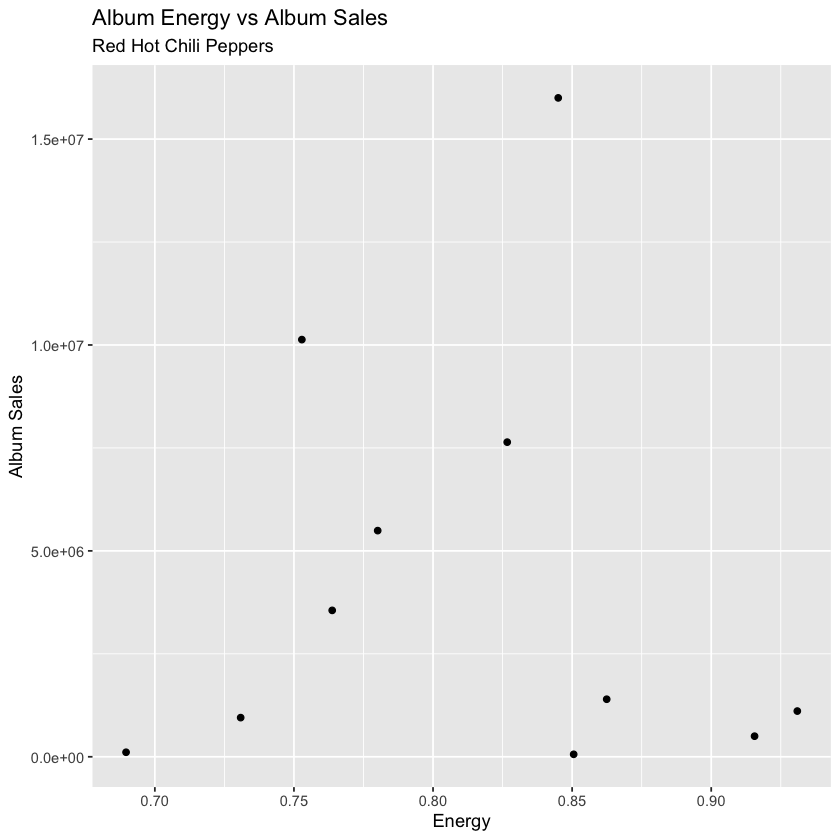

In [41]:
## Scatterplot energy vs sales
ggplot(sales.energy, aes(x = energy, y = sales)) +
  geom_point() +
  xlab("Energy") +
  ylab("Album Sales") +
  ggtitle("Album Energy vs Album Sales", subtitle = "Red Hot Chili Peppers")
## Below energy of 0.85, we see a positive relationship between album energy and
## sales. However, at very high energy levels we see a huge drop in album sales,
## and no observable relationship.

## This suggests that for moderate levels, an increase in energy can be associated
## with an increase in album sales. The non-linearity of the relationship suggests
## that for the RHCP there is a fine line between having enough energy to be fun
## (increase in sales), and hard funk rock that is too intense for mainstream success.

In [42]:
## Correlation
cor(sales.energy$energy, sales.energy$sales)^2
## The relationship is non-linear (piece-wise function) so we observe a very low
## R^2.

[1] NA

In [48]:
energy.ordered$album_name %>% lapply(rym_get_album_rating)

[[1]]
[1] NA

[[2]]
[1] 2.75

[[3]]
[1] 2.94

[[4]]
[1] NA

[[5]]
[1] 3.56

[[6]]
[1] 4.06

[[7]]
[1] 4.13

[[8]]
[1] NA

[[9]]
[1] 3.03

[[10]]
[1] 3.52

[[11]]
[1] NA

[[12]]
[1] 2.94

[[13]]
[1] 3.71

In [49]:
rhcp.rym <- energy.ordered
rhcp.rym$rating <- c(2.43, 2.76, 2.94, 3.26, 3.56, 3.20, 3.46, 3.31, 3.03, 
                     2.63, 2.85, 2.94, 2.78)

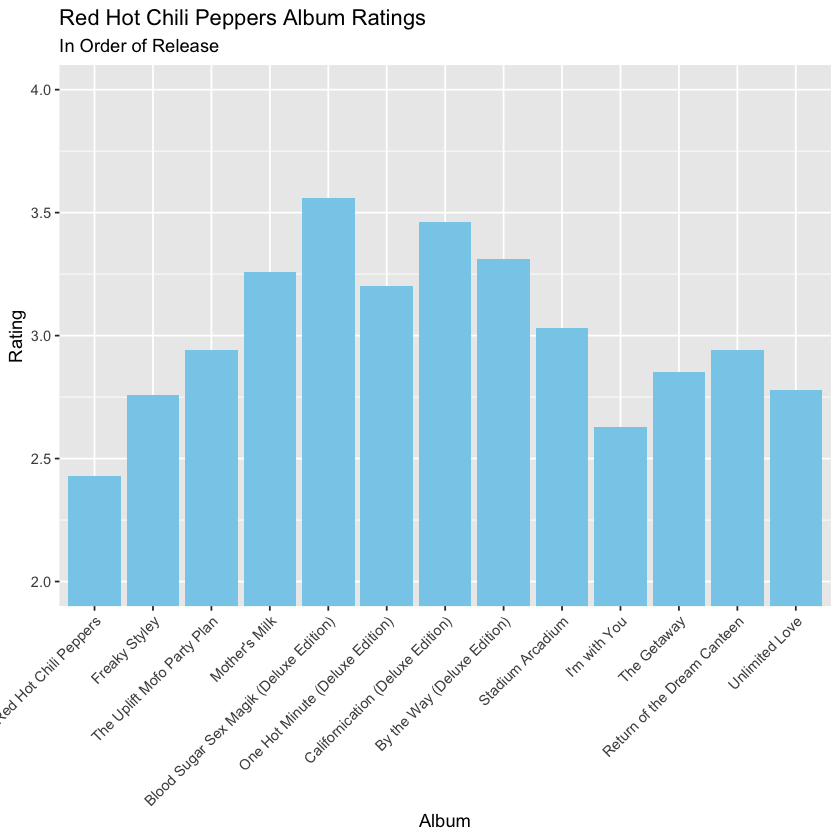

In [50]:
## Plot release vs rating
ggplot(rhcp.rym, aes(x = reorder(album_name, release), y = rating)) +
  geom_bar(stat = "identity", fill = "sky blue") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  xlab("Album") +
  ylab("Rating") +
  coord_cartesian(ylim = c(2,4)) +
  ggtitle("Red Hot Chili Peppers Album Ratings",
          subtitle = "In Order of Release")

In [105]:
## Add sales and remove missing values
rhcp.rym2 <- rhcp.rym
rhcp.rym2$sales <- c(NA, rhcp.sales$Sales[14], 
                             rhcp.sales$Sales[11], rhcp.sales$Sales[9], 
                             rhcp.sales$Sales[2], rhcp.sales$Sales[6], 
                             rhcp.sales$Sales[1], rhcp.sales$Sales[3], 
                             rhcp.sales$Sales[5], rhcp.sales$Sales[8], 
                             rhcp.sales$Sales[10], NA, 
                             rhcp.sales$Sales[13])
rhcp.rym2 <- na.omit(rhcp.rym2)
rhcp.rym2

album_name,energy,release,rating,sales
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Freaky Styley,0.8505556,1985,2.76,60000
The Uplift Mofo Party Plan,0.9155833,1987,2.94,500000
Mother's Milk,0.9309474,1989,3.26,1110000
Blood Sugar Sex Magik (Deluxe Edition),0.7528421,1991,3.56,10130420
One Hot Minute (Deluxe Edition),0.7637500,1995,3.20,3555000
Californication (Deluxe Edition),0.8450000,1999,3.46,16000000
By the Way (Deluxe Edition),0.8266667,2002,3.31,7640368
Stadium Arcadium,0.7801034,2006,3.03,5491949
I'm with You,0.8624286,2011,2.63,1397524


In [106]:
## Correlation rating vs sales
cor(rhcp.rym2$rating, rhcp.rym2$sales)^2
## The relationship is moderate and positive. 63% of the variation in album sales
## can be explained from RYM ratings.

[1] 0.6286604

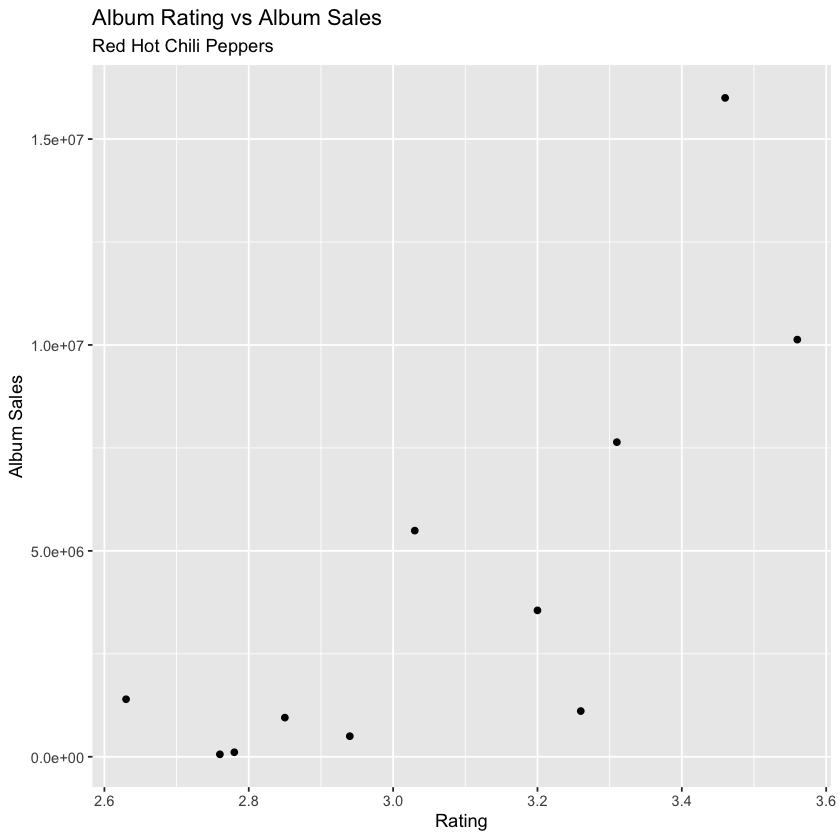

In [107]:
## Scatterplot ratings vs sales
ggplot(rhcp.rym2, aes(x = rating, y = sales)) +
  geom_point() +
  xlab("Rating") +
  ylab("Album Sales") +
  ggtitle("Album Rating vs Album Sales", 
          subtitle = "Red Hot Chili Peppers")
## We can see a positive relationship between album rating and album sales.
## This signifies that an increase in RYM ratings is associated with an increase
## in album sales.

Scrape top 5000 highest rated albums from rateyourmusic.com

In [14]:
# Start iterating from page 1
num_pages <- 125
all_data <- purrr::map_df(1:num_pages, ~ {
  print(paste("Fetching page", .x))
  Sys.sleep(sample(40:45, 1))
  rym_get_album_ratings_highest_page(.x)
})


[1] "Fetching page 1"
[1] "Fetching page 2"
[1] "Fetching page 3"
[1] "Fetching page 4"
[1] "Fetching page 5"


Warning message:
“ 3 failed to parse.”


[1] "Fetching page 6"


Warning message:
“ 1 failed to parse.”


[1] "Fetching page 7"
[1] "Fetching page 8"


Warning message:
“ 1 failed to parse.”


[1] "Fetching page 9"


Warning message:
“ 1 failed to parse.”


[1] "Fetching page 10"


Warning message:
“ 6 failed to parse.”


[1] "Fetching page 11"


Warning message:
“ 4 failed to parse.”


[1] "Fetching page 12"


Warning message:
“ 1 failed to parse.”


[1] "Fetching page 13"


Warning message:
“ 4 failed to parse.”


[1] "Fetching page 14"


Warning message:
“ 4 failed to parse.”


[1] "Fetching page 15"


Warning message:
“ 3 failed to parse.”


[1] "Fetching page 16"


Warning message:
“ 5 failed to parse.”


[1] "Fetching page 17"


Warning message:
“ 13 failed to parse.”


[1] "Fetching page 18"


Warning message:
“ 5 failed to parse.”


[1] "Fetching page 19"


Warning message:
“ 3 failed to parse.”


[1] "Fetching page 20"


Warning message:
“ 2 failed to parse.”


[1] "Fetching page 21"


Warning message:
“ 2 failed to parse.”


[1] "Fetching page 22"


Warning message:
“ 5 failed to parse.”


[1] "Fetching page 23"


Warning message:
“ 11 failed to parse.”


[1] "Fetching page 24"


Warning message:
“ 9 failed to parse.”


[1] "Fetching page 25"


Warning message:
“ 5 failed to parse.”


[1] "Fetching page 26"


Warning message:
“ 1 failed to parse.”


[1] "Fetching page 27"


Warning message:
“ 3 failed to parse.”


[1] "Fetching page 28"


Warning message:
“ 3 failed to parse.”


[1] "Fetching page 29"


Warning message:
“ 8 failed to parse.”


[1] "Fetching page 30"


Warning message:
“ 7 failed to parse.”


[1] "Fetching page 31"


Warning message:
“ 6 failed to parse.”


[1] "Fetching page 32"


Warning message:
“ 3 failed to parse.”


[1] "Fetching page 33"


Warning message:
“ 9 failed to parse.”


[1] "Fetching page 34"


Warning message:
“ 5 failed to parse.”


[1] "Fetching page 35"


Warning message:
“ 6 failed to parse.”


[1] "Fetching page 36"


Warning message:
“ 4 failed to parse.”


[1] "Fetching page 37"


Warning message:
“ 3 failed to parse.”


[1] "Fetching page 38"


Warning message:
“ 6 failed to parse.”


[1] "Fetching page 39"


Warning message:
“ 3 failed to parse.”


[1] "Fetching page 40"


Warning message:
“ 4 failed to parse.”


[1] "Fetching page 41"


Warning message:
“ 5 failed to parse.”


[1] "Fetching page 42"


Warning message:
“ 11 failed to parse.”


[1] "Fetching page 43"


Warning message:
“ 8 failed to parse.”


[1] "Fetching page 44"


Warning message:
“ 6 failed to parse.”


[1] "Fetching page 45"


Warning message:
“ 7 failed to parse.”


[1] "Fetching page 46"


Warning message:
“ 2 failed to parse.”


[1] "Fetching page 47"


Warning message:
“ 9 failed to parse.”


[1] "Fetching page 48"


Warning message:
“ 7 failed to parse.”


[1] "Fetching page 49"


Warning message:
“ 7 failed to parse.”


[1] "Fetching page 50"


Warning message:
“ 8 failed to parse.”


[1] "Fetching page 51"


Warning message:
“ 9 failed to parse.”


[1] "Fetching page 52"


Warning message:
“ 8 failed to parse.”


[1] "Fetching page 53"


Warning message:
“ 5 failed to parse.”


[1] "Fetching page 54"


Warning message:
“ 5 failed to parse.”


[1] "Fetching page 55"


Warning message:
“ 7 failed to parse.”


ERROR: [1m[33mError[39m in `map()`:[22m
[1m[22m[36mℹ[39m In index: 55.
[1mCaused by error in `data.frame()`:[22m
[33m![39m arguments imply differing number of rows: 40, 39


In [ ]:
# Check the data
tail(all_data)

,Album,Artist,Rating,ReleaseDate,Genres,Descriptors,NumberOfRatings,NumberOfViews
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
4995,...And the Battle Begun,Rx Bandits,3.67,14 June 2006,Progressive Rock,"progressive, energetic, warm, melodic, passionate, atmospheric, avant-garde, complex",702,8
4996,The Sullen Sulcus,Mourning Beloveth,3.68,15 December 2002,Death Doom Metal,"melancholic, sombre, depressive, melodic, funereal, heavy, repetitive, death",597,6
4997,Cornonstípicum,M.I.A. (Músicos Independientes Asociados),3.69,1978,"Symphonic Prog, Progressive Rock","melodic, progressive, technical, playful, composition, vocal group, eclectic, energetic",376,13
4998,Браво,Браво,3.69,1987,"Rockabilly, Pop Rock","playful, urban, melodic, eclectic, rhythmic, optimistic",369,2
4999,Let 'Em Roll,Big John Patton,3.70,April 1967,Soul Jazz,"playful, sensual, mellow, rhythmic, instrumental",303,7
5000,Sonny Rollins on Impulse!,Sonny Rollins,3.70,August 1965,Hard Bop,instrumental,313,3


In [15]:
all_data <- read_csv("Top Albums.csv")

# identify the format of possible date
date_formats <- c("d m Y", "m Y", "Y")

# Using parse_date_time function to convert the release date
all_data$ReleaseDate <- parse_date_time2(all_data$ReleaseDate, orders = date_formats)

# Convert to formal dd-mm-yyyy
# all_data$releasedate_formatted <- format(all_data$ReleaseDate, "%d-%m-%Y")

# Extract year from ReleaseDate
# all_data$year <- year(ymd(all_data$ReleaseDate))

# Summarize album sales per year
# yearly_counts <- all_data %>% 
  # group_by(year) %>%
  # summarise(count = n())

all_data

Rows: 5000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Album, Artist, ReleaseDate, Genres, Descriptors
dbl (3): Rating, NumberOfRatings, NumberOfViews

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Album,Artist,Rating,ReleaseDate,Genres,Descriptors,NumberOfRatings,NumberOfViews
<chr>,<chr>,<dbl>,<dttm>,<chr>,<chr>,<dbl>,<dbl>
To Pimp a Butterfly,Kendrick Lamar,4.36,NA,"Conscious Hip Hop, West Coast Hip Hop, Jazz Rap","political, conscious, concept album, poetic, introspective, urban, protest, eclectic",70131,599
OK Computer,Radiohead,4.27,NA,"Alternative Rock, Art Rock","melancholic, anxious, alienation, futuristic, existential, lonely, atmospheric, cold",95227,1718
Wish You Were Here,Pink Floyd,4.32,NA,"Progressive Rock, Art Rock","melancholic, atmospheric, progressive, concept album, serious, longing, introspective, alienation",65613,996
Madvillainy,Madvillain,4.33,NA,Abstract Hip Hop,"sampling, playful, humorous, abstract, cryptic, mysterious, eclectic, surreal",54649,472
In Rainbows,Radiohead,4.29,NA,"Art Rock, Alternative Rock","lush, melancholic, introspective, bittersweet, atmospheric, mellow, warm, ethereal",69050,875
In the Court of the Crimson King,King Crimson,4.31,NA,"Progressive Rock, Art Rock","fantasy, epic, progressive, complex, poetic, surreal, philosophical, technical",60330,947
Kid A,Radiohead,4.25,NA,"Art Rock, Electronic, Experimental Rock","cold, melancholic, futuristic, atmospheric, anxious, cryptic, abstract, sombre",78365,858
"good kid, m.A.A.d city",Kendrick Lamar,4.29,NA,"West Coast Hip Hop, Conscious Hip Hop","urban, concept album, crime, conscious, introspective, passionate, violence, Christian",59159,392
Loveless,My Bloody Valentine,4.25,NA,"Shoegaze, Noise Pop","noisy, ethereal, atmospheric, romantic, hypnotic, dense, love, psychedelic",68318,1372


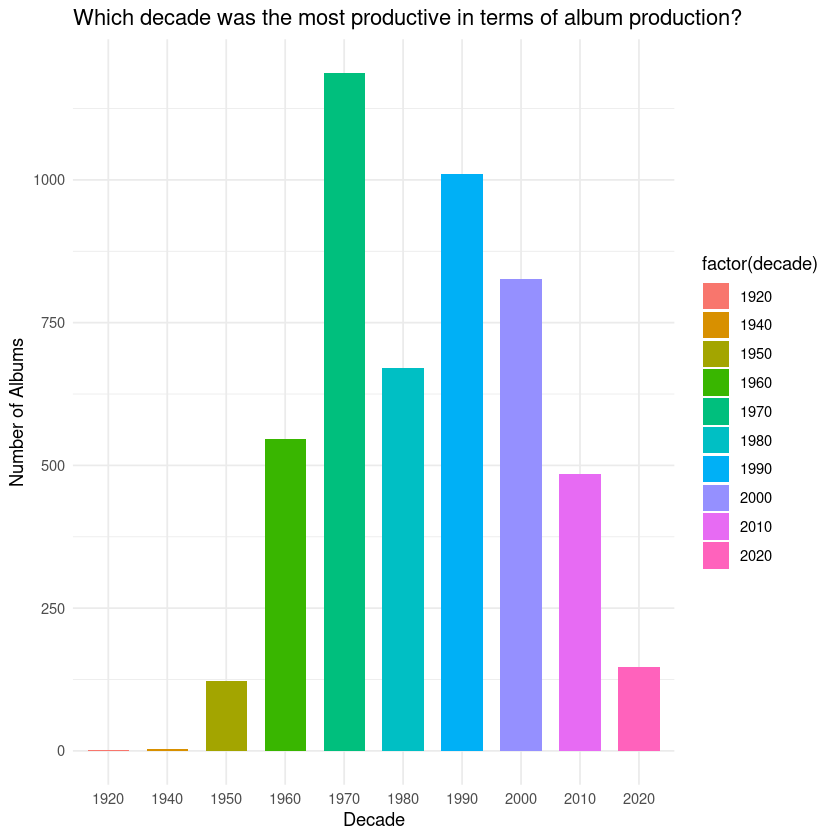

In [ ]:
# Create a new variable for the decade
all_data$decade <- 10 * (all_data$year %/% 10)

# Plotting
ggplot(all_data, aes(x=factor(decade), fill=factor(decade))) + 
  geom_bar(width=0.7) +  
  labs(title="Number of albums in the top 5000 highest rated albums on rateyourmusic.com, by decade",
       x="Decade",
       y="Number of Albums") + 
  theme_minimal() +
  scale_x_discrete(breaks = unique(all_data$decade))

In [4]:
# Plot the data
p <- ggplot(yearly_counts, aes(x = year, y = count)) +
  geom_bar(stat = "identity", fill = "blue") +
  geom_text(aes(label = count), vjust = -0.5) +
  scale_x_continuous(breaks = seq(min(yearly_counts$year), max(yearly_counts$year), by = 5)) +
  labs(title = "Number of albums in the top 5000 highest rated albums on rateyourmusic.com, by year", x = "Year", y = "Number of Albums") +
  theme_minimal()
# Display the plot
print(p)

ERROR: Error in seq.default(min(yearly_counts$year), max(yearly_counts$year), : 'from' must be a finite number


In [1]:
# Print the most highly rated year in the top 5000 on rateyourmusic.com
max_year <- yearly_counts[which.max(yearly_counts$count), ]
cat(paste("The most highly rated year in the top 5000 was", max_year$year, "with", max_year$count, "albums."))

[1] "The most highly rated year in the top 5000 was 1971 with 155 albums sold."


In [ ]:
# Separate rows where genre contains commas or another delimiter
all_data_separated <- all_data %>%
  separate_rows(Genres, sep = ",") %>%   # Replace "," with your delimiter if different
  mutate(Genres = trimws(Genres))   # Remove any white space

# Now, re-calculate the genre count
genre_count <- all_data_separated %>%
  group_by(Genres) %>%
  summarise(Count = n()) %>%
  arrange(-Count)

# Select the top 10 genres with the most comments
top_10_genres <- head(genre_count, 10)$Genres

# Filter the data to include only these top 10 genres
filtered_data <- all_data_separated %>% 
  filter(Genres %in% top_10_genres)

In [ ]:
# Create a corpus from the 'descriptors' column
corpus <- Corpus(VectorSource(all_data$Descriptors))

# Clean the corpus: convert to lowercase, remove numbers, punctuation, whitespace, and common stopwords
corpus <- corpus %>%
  tm_map(removePunctuation) %>%
  tm_map(stripWhitespace)
corpus <- tm_map(corpus, content_transformer(tolower))
corpus <- tm_map(corpus, removeWords, stopwords("english"))

# Create a matrix
descriptor_tm <- TermDocumentMatrix(corpus) 
descriptor_matrix <- as.matrix(descriptor_tm) 
descriptor_words <- sort(rowSums(descriptor_matrix),decreasing=TRUE) 
descriptor_df <- data.frame(word = names(descriptor_words), freq=descriptor_words)

Warning message in tm_map.SimpleCorpus(., removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., stripWhitespace):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, content_transformer(tolower)):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, removeWords, stopwords("english")):
“transformation drops documents”


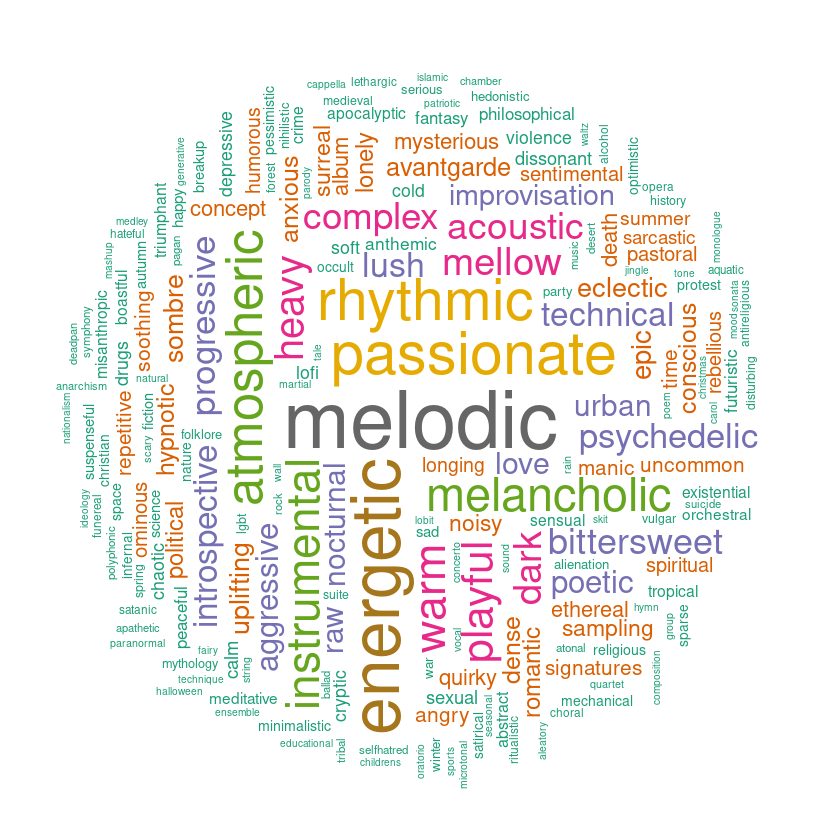

In [ ]:
# Generate the Word Cloud
descriptor_word_cloud <- wordcloud(words = descriptor_df$word, 
                                   freq = descriptor_df$freq, 
                                   min.freq = 1,           
                                   max.words = 4000, 
                                   random.order = FALSE, 
                                   rot.per = 0.5,            
                                   colors = brewer.pal(8, "Dark2"))